# Show how to save and restore data to/from pandas data frames and parquet files


In [1]:
%load_ext autoreload
%autoreload

In [2]:
import sys
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts, compute_distance_spot_to_spot
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2


plt.rcParams['font.size']=16

In [3]:
# build reference telescope
telescope = tweak_optics.build_telescope("../data/LSST_CCOB_r.yaml")
tweak_optics.make_optics_reflective(telescope, coating='smart', r_frac=[0.02, 0.02, 0.15])

0

In [4]:
# use a polar beam set of 35 configurations
polar_beam_set = beam.build_full_frame_polar_set(base_id=0, set_size='test')
polar_beam_df = beam.concat_dicts(polar_beam_set)
polar_beam_df.head()


,beam_id,wl,n_photons,radius,x_offset,y_offset,z_offset,z_euler,y_euler,x_euler,base_id
0,0,5.000000e-07,100,0.00125,0.00,0.000000e+00,2.2,0.0,0.0,0.0,0
1,1,5.000000e-07,100,0.00125,0.18,0.000000e+00,2.2,0.0,0.0,0.0,0
2,2,5.000000e-07,100,0.00125,-0.09,1.558846e-01,2.2,0.0,0.0,0.0,0
3,3,5.000000e-07,100,0.00125,-0.09,-1.558846e-01,2.2,0.0,0.0,0.0,0
4,4,5.000000e-07,100,0.00125,0.18,-4.408728e-17,2.2,0.0,0.0,0.0,0


In [5]:
# show impact points with default geometry
polar_impact_df = simulator.simulate_impact_points_for_beam_set(telescope, polar_beam_set)


0

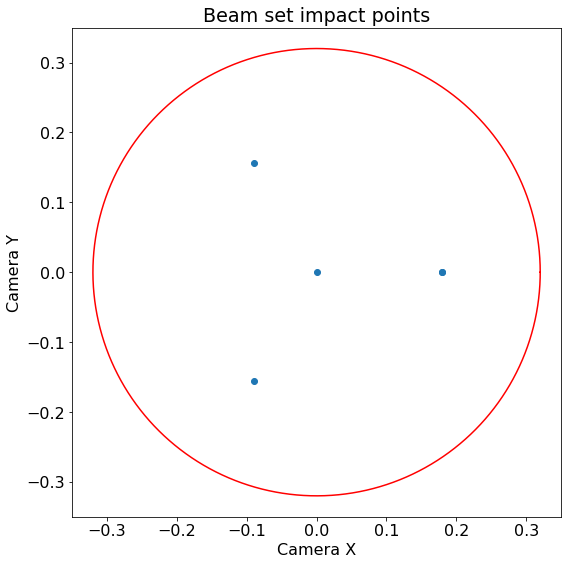

In [6]:
plotter.plot_impact_points_full_frame(polar_impact_df)

In [7]:
# build a set of 100 random geometries
geom_set = []
for i in range(5):
    geom_set.append(geom.build_random_geom(max_angle=0.1, max_shift=0.001))


In [8]:
# geom set data frame
geom_set_df = geom.concat_dicts(geom_set)    
geom_set_df.head()

,geom_id,L1_dx,L1_dy,L1_dz,L1_rx,L1_ry,L1_rz,L2_dx,L2_dy,L2_dz,...,Filter_dz,Filter_rx,Filter_ry,Filter_rz,Detector_dx,Detector_dy,Detector_dz,Detector_rx,Detector_ry,Detector_rz
921812266,921812266,-0.000799,-0.000850,0.000790,0.025203,0.045005,0.046635,0.000114,0.000950,0.000138,...,0.000624,0.058428,-0.000007,0.078816,-0.000990,-0.000766,0.000040,-0.093682,-0.001851,0.027618
999443677,999443677,-0.000724,-0.000712,-0.000867,-0.036512,-0.075072,-0.092016,0.000038,-0.000941,-0.000440,...,0.000222,-0.006224,0.054778,0.075758,-0.000550,-0.000449,0.000891,0.006180,0.017787,-0.011678
808211196,808211196,0.000609,0.000200,0.000933,0.067071,0.022706,-0.069732,0.000209,-0.000539,0.000191,...,0.000521,0.055734,-0.071958,0.055957,0.000552,0.000170,0.000233,0.084955,0.040989,0.065812
398978314,398978314,-0.000205,0.000692,0.000720,0.026735,-0.081978,-0.052966,0.000556,-0.000835,-0.000441,...,-0.000991,0.075561,-0.012803,-0.073067,0.000464,0.000247,-0.000767,0.017861,0.064794,-0.001064
530133526,530133526,-0.000777,0.000991,0.000935,0.066503,0.085772,0.004466,-0.000590,0.000739,0.000345,...,0.000924,0.085807,0.010731,-0.039384,-0.000280,0.000721,-0.000355,-0.028078,-0.026551,-0.022800


In [9]:
# run simulations for all beams and all geometry configuratoins
spots_data_frame = simulator.run_and_analyze_simulation_for_configs_sets(geom_set, polar_beam_set)


In [10]:
sims_spots_df = pd.concat(spots_data_frame)
sims_spots_df.head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
0,0,921812266,0,"(L1_exit, L1_entrance)",-0.000028,0.000288,-3.251113e-06,0.000288,0.001077,0.001085,0.001081,4.255072e-06,0.034725,3.672430,561.951376
1,0,921812266,1,"(L2_exit, L1_entrance)",-0.000089,0.000925,-1.045021e-05,0.000925,0.003462,0.003489,0.003475,1.367729e-05,0.032029,37.943693,50.166861
2,0,921812266,2,"(L2_exit, L1_exit)",-0.000136,0.001420,-1.604894e-05,0.001420,0.005316,0.005358,0.005337,2.100494e-05,0.033350,89.491647,22.147355
3,0,921812266,3,"(L2_entrance, L1_entrance)",-0.000002,0.000018,-1.995984e-07,0.000018,0.000066,0.000067,0.000066,2.612322e-07,0.033350,0.013842,143188.327274
4,0,921812266,4,"(L2_entrance, L1_exit)",-0.000034,0.000357,-4.040158e-06,0.000357,0.001338,0.001349,0.001344,5.287777e-06,0.034725,5.671344,363.886708


In [11]:
unique_geom_ids = list(set(sims_spots_df['geom_id']))

sims_spots_df[(sims_spots_df['beam_id']==2) & (sims_spots_df['geom_id']==unique_geom_ids[2])].head()

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
0,2,530133526,0,"(L1_exit, L1_entrance)",-0.039954,0.000254,0.069143,0.000254,0.001010,0.001062,0.001036,0.000026,0.034725,3.372849,611.864633
1,2,530133526,1,"(L2_exit, L1_entrance)",-0.128170,0.000815,0.221807,0.000815,0.003238,0.003398,0.003318,0.000080,0.032029,34.585499,55.037978
2,2,530133526,2,"(L2_entrance, L1_entrance)",-0.002054,0.000012,0.003554,0.000012,0.000050,0.000038,0.000044,0.000006,0.033350,0.006093,325276.160826
3,2,530133526,3,"(L2_entrance, L1_exit)",-0.049633,0.000316,0.085893,0.000316,0.001254,0.001319,0.001287,0.000032,0.034725,5.201557,396.751791
4,2,530133526,4,"(L2_exit, L2_entrance)",-0.152068,0.000981,0.263164,0.000981,0.003865,0.004180,0.004022,0.000157,0.034725,50.829343,40.601093


In [12]:
# join spots, beam and geom data frame
print('Merging beam and spots')
new_df = polar_beam_df.join(sims_spots_df.set_index('beam_id'), on='beam_id', lsuffix='_beam')
print('Merging beam and spots and geom')
final_df = geom_set_df.join(new_df.set_index('geom_id'), on='geom_id', lsuffix='_geom')
# attributing a prod number
final_df.attrs['production'] = 'test_prod_1'

Merging beam and spots
Merging beam and spots and geom


In [13]:
# Try to build a multi index
iterables = [list(set(geom_set_df['geom_id'])), list(set(polar_beam_df['beam_id'])),
             list(set(sims_spots_df['index']))]
fine_index = pd.MultiIndex.from_product(iterables, names=["geom_id", "beam_id", "spot_id"])
#final_df.set_index(fine_index)

In [14]:
# Have a look at data frame
final_df.head()

,geom_id,L1_dx,L1_dy,L1_dz,L1_rx,L1_ry,L1_rz,L2_dx,L2_dy,L2_dz,...,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
921812266,921812266,-0.000799,-0.00085,0.00079,0.025203,0.045005,0.046635,0.000114,0.00095,0.000138,...,0.000288,-3.251113e-06,0.000288,0.001077,0.001085,0.001081,4.255072e-06,0.034725,3.672430,561.951376
921812266,921812266,-0.000799,-0.00085,0.00079,0.025203,0.045005,0.046635,0.000114,0.00095,0.000138,...,0.000925,-1.045021e-05,0.000925,0.003462,0.003489,0.003475,1.367729e-05,0.032029,37.943693,50.166861
921812266,921812266,-0.000799,-0.00085,0.00079,0.025203,0.045005,0.046635,0.000114,0.00095,0.000138,...,0.001420,-1.604894e-05,0.001420,0.005316,0.005358,0.005337,2.100494e-05,0.033350,89.491647,22.147355
921812266,921812266,-0.000799,-0.00085,0.00079,0.025203,0.045005,0.046635,0.000114,0.00095,0.000138,...,0.000018,-1.995984e-07,0.000018,0.000066,0.000067,0.000066,2.612322e-07,0.033350,0.013842,143188.327274
921812266,921812266,-0.000799,-0.00085,0.00079,0.025203,0.045005,0.046635,0.000114,0.00095,0.000138,...,0.000357,-4.040158e-06,0.000357,0.001338,0.001349,0.001344,5.287777e-06,0.034725,5.671344,363.886708


In [15]:
# Have a look at data frame
final_df.keys()

Index(['geom_id', 'L1_dx', 'L1_dy', 'L1_dz', 'L1_rx', 'L1_ry', 'L1_rz',
       'L2_dx', 'L2_dy', 'L2_dz', 'L2_rx', 'L2_ry', 'L2_rz', 'L3_dx', 'L3_dy',
       'L3_dz', 'L3_rx', 'L3_ry', 'L3_rz', 'Filter_dx', 'Filter_dy',
       'Filter_dz', 'Filter_rx', 'Filter_ry', 'Filter_rz', 'Detector_dx',
       'Detector_dy', 'Detector_dz', 'Detector_rx', 'Detector_ry',
       'Detector_rz', 'beam_id', 'wl', 'n_photons', 'radius_beam', 'x_offset',
       'y_offset', 'z_offset', 'z_euler', 'y_euler', 'x_euler', 'base_id',
       'index', 'name', 'pos_x', 'std_x', 'pos_y', 'std_y', 'width_x',
       'width_y', 'radius', 'radius_err', 'flux', 'surface', 'pixel_signal'],
      dtype='object')

In [16]:
# try to get one simulation output
final_df[(final_df['beam_id']==2) & (final_df['geom_id']==unique_geom_ids[2])][['geom_id', 'beam_id', 'name', 'index', 'pos_x', 'pos_y', 'pixel_signal']]

,geom_id,beam_id,name,index,pos_x,pos_y,pixel_signal
530133526,530133526,2,"(L1_exit, L1_entrance)",0,-0.039954,0.069143,611.864633
530133526,530133526,2,"(L2_exit, L1_entrance)",1,-0.128170,0.221807,55.037978
530133526,530133526,2,"(L2_entrance, L1_entrance)",2,-0.002054,0.003554,325276.160826
530133526,530133526,2,"(L2_entrance, L1_exit)",3,-0.049633,0.085893,396.751791
530133526,530133526,2,"(L2_exit, L2_entrance)",4,-0.152068,0.263164,40.601093
530133526,530133526,2,"(L3_exit, L1_entrance)",5,0.023630,-0.040893,1400.572201
530133526,530133526,2,"(L3_exit, L1_exit)",6,-0.010148,0.017563,9056.031839
530133526,530133526,2,"(L3_exit, L2_entrance)",7,-0.059747,0.103397,255.967263
530133526,530133526,2,"(L3_exit, L2_exit)",8,-0.016651,0.028815,3597.196286
530133526,530133526,2,"(L3_entrance, L1_entrance)",9,-0.134789,0.233262,47.637658


In [17]:
# what size is that in memory for 20 simulations?
print(f'Size of data frame is {sys.getsizeof(final_df)/1e6} MB')
print(f'This means around 400 GB for 1 Million of simulations.')

Size of data frame is 0.239136 MB
This means around 400 GB for 1 Million of simulations.


In [18]:
# note that the ghost name column is as big as one column of floats
sys.getsizeof(final_df['name'])/1e6, sys.getsizeof(final_df['pos_x'])/1e6

(0.027456, 0.007856)

## Now testing storage on disk

In [19]:
# first each data frame by itself
polar_beam_df.to_parquet('beams.parquet')
geom_set_df.to_parquet('geoms.parquet')
sims_spots_df.to_parquet('ghosts.parquet')
final_df.to_parquet('test_prod_1.parquet')

In [20]:
!ls -lhrt *.parquet

-rw-r--r-- 1 bregeon ams 8.6K Sep 23 14:16 beams.parquet
-rw-r--r-- 1 bregeon ams  23K Sep 23 14:16 geoms.parquet
-rw-r--r-- 1 bregeon ams  56K Sep 23 14:16 ghosts.parquet
-rw-r--r-- 1 bregeon ams  83K Sep 23 14:16 test_prod_1.parquet


## What about reading this back from file

In [21]:
sim_df = pd.read_parquet('test_prod_1.parquet')

In [22]:
test_sim = sim_df[(sim_df['beam_id']==2) & (sim_df['geom_id']==unique_geom_ids[2])][['geom_id', 'beam_id', 'name', 'index', 'pos_x', 'pos_y', 'pixel_signal']]
test_sim.head()

,geom_id,beam_id,name,index,pos_x,pos_y,pixel_signal
530133526,530133526,2,"[L1_exit, L1_entrance]",0,-0.039954,0.069143,611.864633
530133526,530133526,2,"[L2_exit, L1_entrance]",1,-0.128170,0.221807,55.037978
530133526,530133526,2,"[L2_entrance, L1_entrance]",2,-0.002054,0.003554,325276.160826
530133526,530133526,2,"[L2_entrance, L1_exit]",3,-0.049633,0.085893,396.751791
530133526,530133526,2,"[L2_exit, L2_entrance]",4,-0.152068,0.263164,40.601093


In [23]:
one_sim = sim_df[(sim_df['beam_id']==2) & (sim_df['geom_id']==unique_geom_ids[2])]

(<Figure size 1728x1728 with 6 Axes>,
 array([<AxesSubplot:title={'center':'pos_x'}, xlabel='pos_x (mm)'>,
        <AxesSubplot:title={'center':'pos_y'}, xlabel='pos_y (mm)'>,
        <AxesSubplot:title={'center':'radius'}, xlabel='radius (mm)'>,
        <AxesSubplot:title={'center':'surface'}, xlabel='spot surface (mm$^2$)'>,
        <AxesSubplot:title={'center':'pixel signal'}, xlabel='log10(signal) ($e^-$/pixel)'>,
        <AxesSubplot:>], dtype=object))

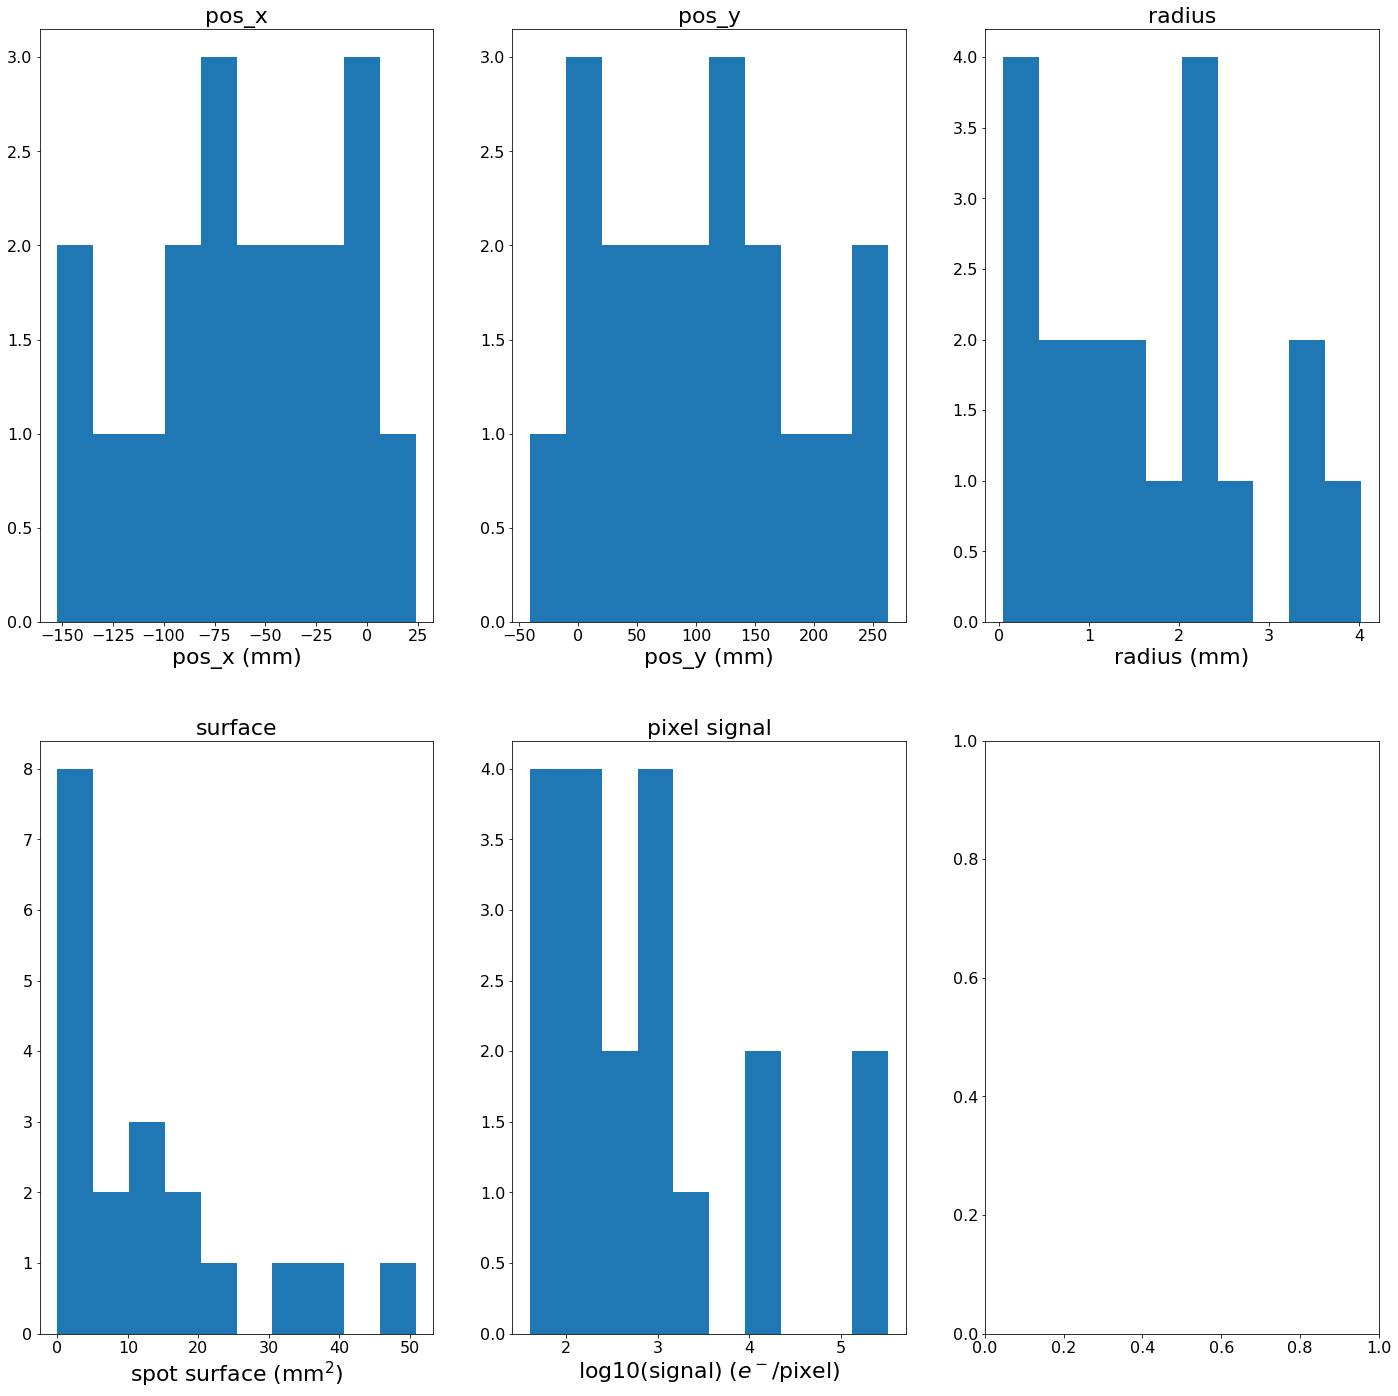

In [24]:
plotter.plot_spots_stats(one_sim)

(<Figure size 864x864 with 1 Axes>, <AxesSubplot:>)

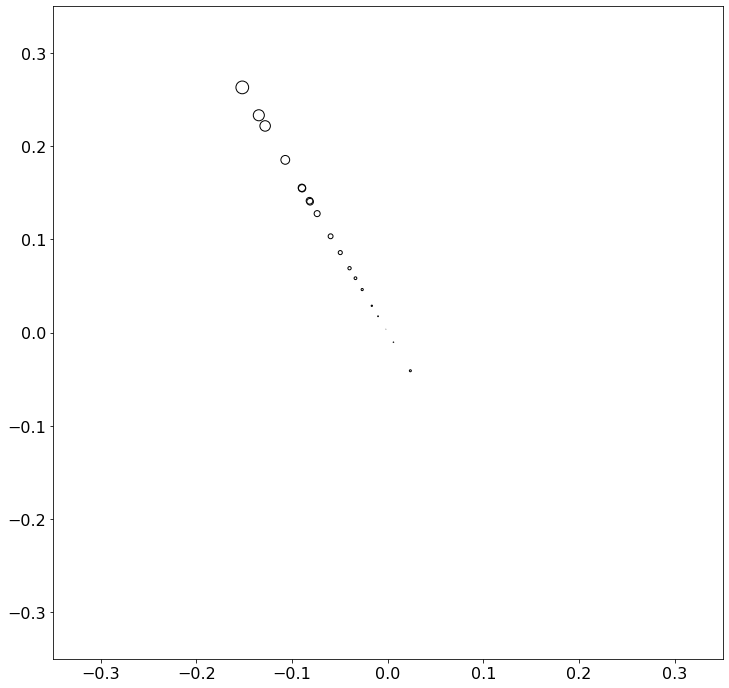

In [25]:
plotter.plot_spots([one_sim])

In [26]:
distances_2d = []
beam_id_set = list(set(sim_df['beam_id']))
print(beam_id_set)
geom_id_set = list(set(sim_df['geom_id']))
print(geom_id_set)
for bid in beam_id_set:
    for gid in geom_id_set:
        ref_data_frame = sim_df[(sim_df['beam_id']==bid) & (sim_df['geom_id']==geom_id_set[0])].set_index('index')
        current_df = sim_df[(sim_df['beam_id']==bid) & (sim_df['geom_id']==gid)].set_index('index')
        matches = match_ghosts(ref_data_frame, current_df)
        dist2d = compute_2d_reduced_distance(matches)
        distances_2d.append(dist2d)
print(distances_2d)

[0, 1, 2, 3, 4]
[921812266, 398978314, 530133526, 808211196, 999443677]
[0.0, 1.3790714068264804e-05, 1.4330002473269263e-05, 1.125393895865783e-05, 1.3942190326126014e-05, 0.0, 1.979025187302522e-05, 2.1707780384026023e-05, 1.0240957382147572e-05, 1.98040543370788e-05, 0.0, 4.225292445543968e-05, 1.703575858272906e-05, 3.138839971046927e-05, 4.364654065413796e-05, 0.0, 2.141913349508859e-05, 4.615825619582507e-06, 2.939258729997265e-06, 2.5602753398790494e-06, 0.0, 1.7582748898285882e-05, 1.0959715006976284e-05, 2.511767574191583e-05, 1.2469278841080875e-05]


(array([7., 1., 4., 4., 5., 1., 0., 1., 0., 2.]),
 array([0.00000000e+00, 4.36465407e-06, 8.72930813e-06, 1.30939622e-05,
        1.74586163e-05, 2.18232703e-05, 2.61879244e-05, 3.05525785e-05,
        3.49172325e-05, 3.92818866e-05, 4.36465407e-05]),
 <BarContainer object of 10 artists>)

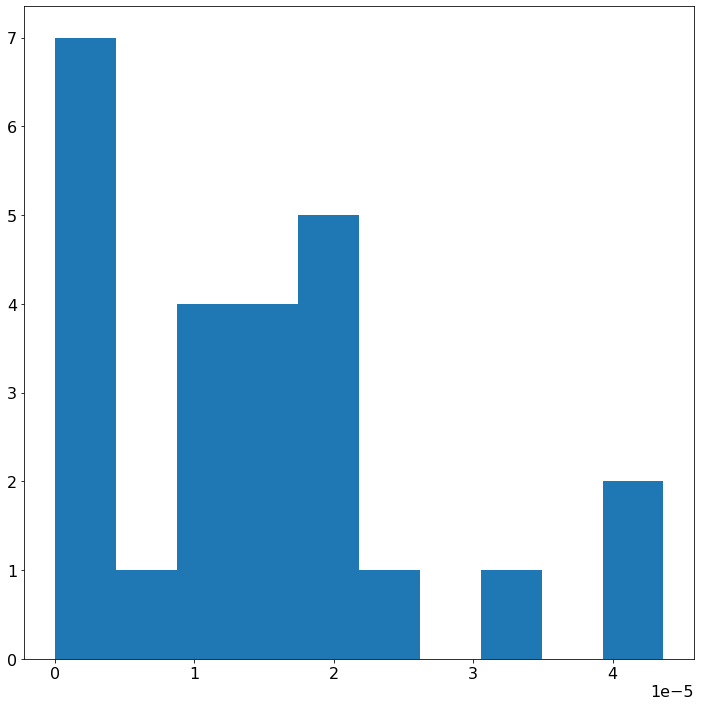

In [27]:
plt.hist(distances_2d)

In [28]:
# trying to rebuild a geometry and a beam config
geoms = list(set(sim_df['geom_id']))
my_geom = sim_df[sim_df['geom_id'] == geoms[2]].iloc[0]
my_beam = sim_df[sim_df['beam_id'] == 2].iloc[0]


Direct path is number 12
  central impact point is (-0.089476, 0.154768)
  transmission is 0.7530

Maximum expected flux is 0.7530
Maximum bin content is 61.9691


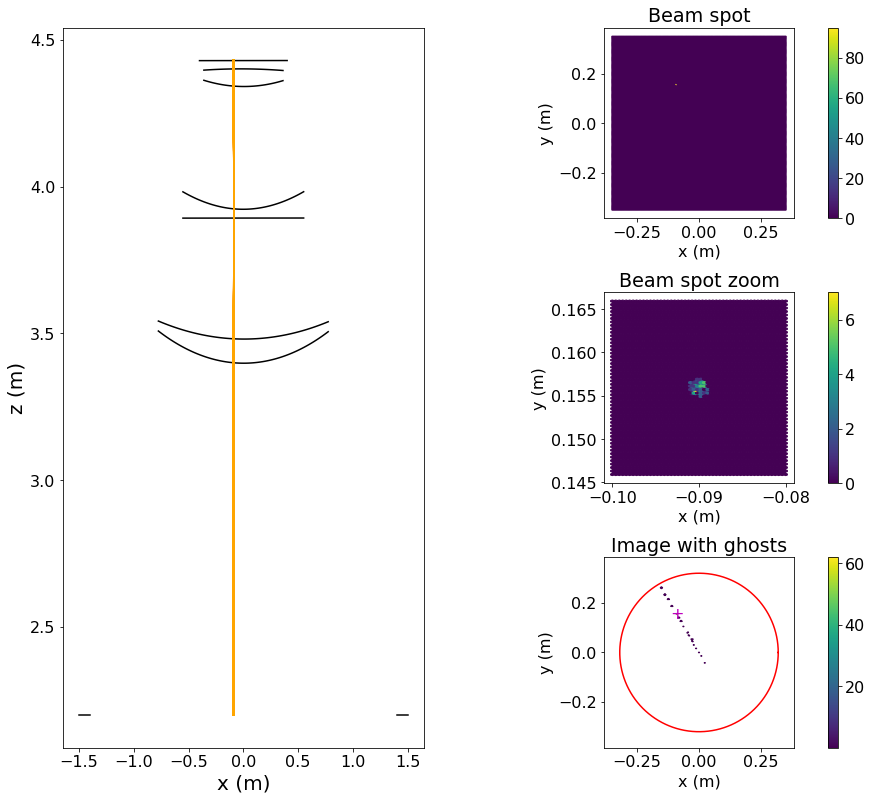

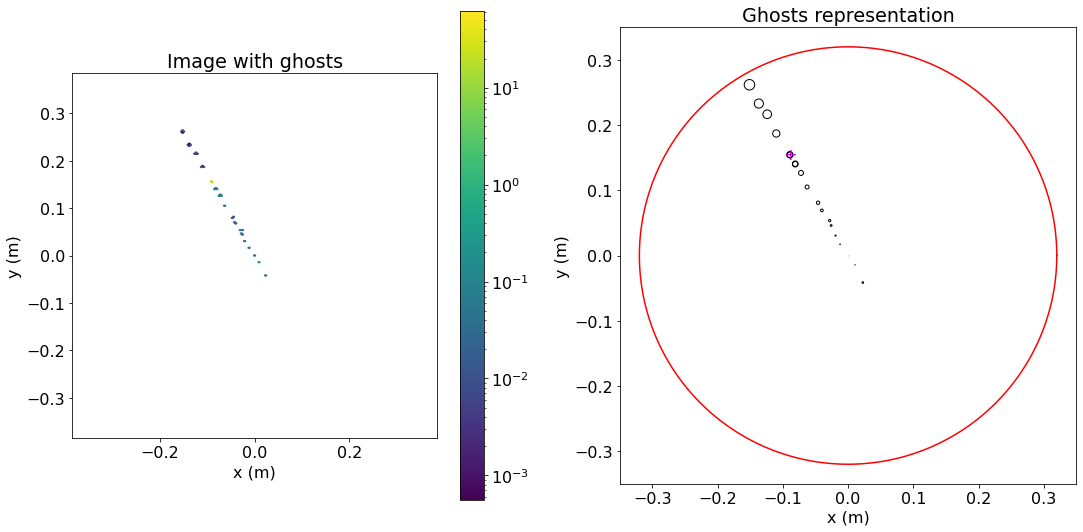

In [29]:
# and rerun the simulation
telescope = tweak_optics.build_telescope_from_geom(my_geom)
tweak_optics.make_optics_reflective(telescope, coating='smart', r_frac=[0.02, 0.02, 0.15])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=my_beam.to_dict())
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
data_frame = make_data_frame(spots_data)
_fig, _ax = plotter.plot_full_camera_and_spots(r_forward, data_frame, log_scale=True)